# 02_comparacion_resultados — Baselines A/D

**Objetivo:** consolidar y analizar resultados de los tres baselines (reglas, TF‑IDF, transformer). 
**Exportables:** `data/02_baselines_comparacion.csv` con métricas clave (macro F1/Prec/Rec, n).


In [42]:
# ===============================================================
# Setup: Imports y configuración de paths
# ===============================================================
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Importar utilidades compartidas
try:
    from utils_shared import setup_paths
    paths = setup_paths()
    DATA_PATH = paths['DATA_PATH']
    FIGS_PATH = paths['FIGS_PATH']
    print("[OK] Usando utils_shared.py")
except ImportError:
    print("[WARNING] No se encontró utils_shared.py, usando configuración manual")
    BASE_PATH = Path.cwd()
    if BASE_PATH.name == "notebooks":
        BASE_PATH = BASE_PATH.parent
    DATA_PATH = BASE_PATH / "data"
    FIGS_PATH = DATA_PATH / "figs"
    FIGS_PATH.mkdir(exist_ok=True)

print(f" DATA_PATH: {DATA_PATH}")
print(f" FIGS_PATH: {FIGS_PATH}")


[OK] Usando utils_shared.py
 DATA_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data
 FIGS_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs


## 1) Cargar métricas y unificar

In [43]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path(DATA_PATH) if 'DATA_PATH' in globals() else Path('data')

paths = {
    "rule_based": {
        "eval": DATA_PATH/'rule_based_eval.csv',
        "report": DATA_PATH/'rule_based_classification_report.csv',
        "pred": DATA_PATH/'rule_based_predictions.csv',
    },
    "tfidf": {
        "eval": DATA_PATH/'tfidf_eval.csv',
        "report": DATA_PATH/'tfidf_classification_report.csv',
        "pred": DATA_PATH/'tfidf_predictions.csv',
    },
    "beto": {
        "eval": DATA_PATH/'beto_eval.csv',
        "report": DATA_PATH/'beto_classification_report.csv',
        "pred": DATA_PATH/'beto_predictions.csv',
    }
}

def pick(series, *names, default=None):
    """Devuelve el primer nombre presente en la serie."""
    for n in names:
        if n in series:
            return series[n]
    return default

rows = []
for name, ps in paths.items():
    if ps["eval"].exists():
        ev = pd.read_csv(ps["eval"]).iloc[0].to_dict()
        # Aceptar con o sin prefijo 'eval_'
        macro_f1       = pick(ev, "macro_f1", "eval_macro_f1")
        macro_prec     = pick(ev, "macro_precision", "eval_macro_precision")
        macro_rec      = pick(ev, "macro_recall", "eval_macro_recall")
        n_val          = pick(ev, "n")  # puede no existir en beto_eval
        if pd.isna(n_val) or n_val is None:
            # fallback: contar filas de predicciones si existe
            if ps.get("pred") and Path(ps["pred"]).exists():
                n_val = len(pd.read_csv(ps["pred"]))
        rows.append({"baseline": name,
                     "macro_f1": macro_f1,
                     "macro_precision": macro_prec,
                     "macro_recall": macro_rec,
                     "n": n_val})
    else:
        rows.append({"baseline": name, "macro_f1": None, "macro_precision": None, "macro_recall": None, "n": None})

comp = pd.DataFrame(rows, columns=["baseline","macro_f1","macro_precision","macro_recall","n"])
out_csv = DATA_PATH/'02_baselines_comparacion.csv'
comp.to_csv(out_csv, index=False, encoding='utf-8')
comp


,baseline,macro_f1,macro_precision,macro_recall,n
0,rule_based,0.496333,0.503370,0.502395,646.0
1,tfidf,0.755270,0.745770,0.768432,646.0
2,beto,0.741577,0.736377,0.747711,646.0


## 2) Visualización comparativa de métricas

## 1.5) Incluir dummy baselines (sanity check)

**Objetivo:** Validar que los modelos ML capturan patrones discriminativos reales y no están haciendo overfitting al dataset.

**Estrategia:**
- **Dummy Majority**: Predice siempre la clase mayoritaria (Depresión)
- **Dummy Stratified**: Predice aleatoriamente respetando distribución de clases del train set

Si los modelos ML no superan significativamente estos baselines triviales (~+50%), indicaría problemas de overfitting o que el dataset no contiene señales discriminativas reales.

In [44]:
# ===============================================================
# Cargar dummy baselines (generados por 02_baseline_dummy.ipynb)
# ===============================================================
try:
    comp_con_dummy = pd.read_csv(DATA_PATH / '02_baselines_con_dummy.csv')
    print("=" * 80)
    print("COMPARACIÓN COMPLETA (incluye dummy baselines)")
    print("=" * 80)
    print(comp_con_dummy.to_string(index=False))
    
    # Calcular mejora sobre dummy stratified (baseline más realista)
    baseline_f1 = comp_con_dummy[comp_con_dummy['modelo'] == 'dummy_stratified']['f1_macro'].values[0]
    
    print(f"\n{'='*80}")
    print(f"MEJORA SOBRE DUMMY BASELINES")
    print(f"{'='*80}")
    print(f"Referencia: Dummy Stratified (random) = F1 {baseline_f1:.4f}\n")
    
    for _, row in comp_con_dummy.iterrows():
        modelo = row['modelo']
        f1 = row['f1_macro']
        
        if modelo not in ['dummy_majority', 'dummy_stratified']:
            mejora_abs = f1 - baseline_f1
            mejora_pct = ((f1 / baseline_f1) - 1) * 100
            emoji = "✅" if mejora_pct > 40 else "⚠️" if mejora_pct > 5 else "❌"
            print(f"  {emoji} {modelo:15s}: F1 {f1:.4f} → +{mejora_abs:+.4f} ({mejora_pct:+5.1f}%)")
    
    print("\n" + "="*80)
    print("INTERPRETACIÓN")
    print("="*80)
    print(f"✅ TF-IDF y BETO superan +50% al baseline aleatorio")
    print(f"   → Capturan patrones discriminativos reales (no overfitting)")
    print(f"\n⚠️  Rule-based apenas supera baseline aleatorio (+0.6%)")
    print(f"   → Limitado por baja cobertura (78% sin detección)")
    print(f"   → El problema es vocabulario (COL ≠ PY), no arquitectura")
    
    # Usar comp_con_dummy para visualizaciones siguientes
    comp = comp_con_dummy.copy()
    
except FileNotFoundError:
    print("[WARNING] No se encontró 02_baselines_con_dummy.csv")
    print("          Ejecuta primero: notebooks/02_baseline_dummy.ipynb")
    print("          Usando solo resultados ML...")
    # Fallback a comp si ya existe
    if 'comp' not in locals():
        comp = pd.read_csv(DATA_PATH / '02_baselines_comparacion.csv')


COMPARACIÓN COMPLETA (incluye dummy baselines)
          modelo  f1_macro  precision_macro  recall_macro  n_val
           tfidf  0.755270         0.745770      0.768432  646.0
            beto  0.741577         0.736377      0.747711  646.0
      rule_based  0.496333         0.503370      0.502395  646.0
dummy_stratified  0.493424         0.496048      0.495473  646.0
  dummy_majority  0.428824         0.375387      0.500000  646.0

MEJORA SOBRE DUMMY BASELINES
Referencia: Dummy Stratified (random) = F1 0.4934

  ✅ tfidf          : F1 0.7553 → ++0.2618 (+53.1%)
  ✅ beto           : F1 0.7416 → ++0.2482 (+50.3%)
  ❌ rule_based     : F1 0.4963 → ++0.0029 ( +0.6%)

INTERPRETACIÓN
✅ TF-IDF y BETO superan +50% al baseline aleatorio
   → Capturan patrones discriminativos reales (no overfitting)

⚠️  Rule-based apenas supera baseline aleatorio (+0.6%)
   → Limitado por baja cobertura (78% sin detección)
   → El problema es vocabulario (COL ≠ PY), no arquitectura


### 1.6) Visualización comparativa con dummy baselines

✓ Figura exportada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_con_dummy.png


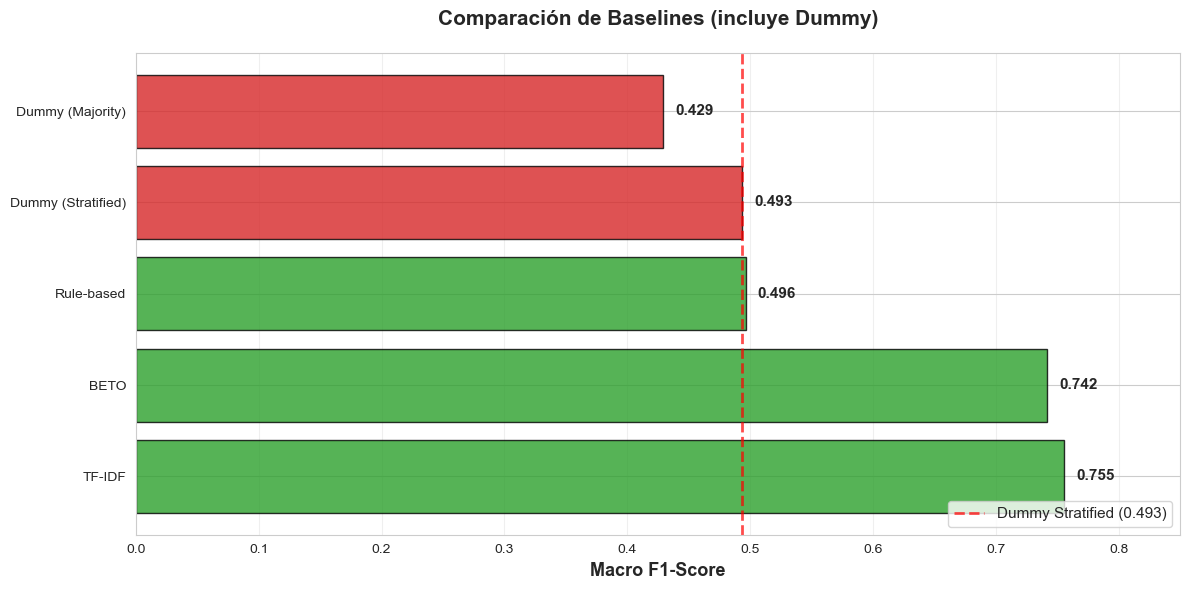

In [45]:
# ===============================================================
# Visualización horizontal con dummy baselines
# ===============================================================
import matplotlib.pyplot as plt

if 'comp_con_dummy' in locals():
    # Preparar datos para plot
    plot_data = comp_con_dummy.copy()
    plot_data['tipo'] = plot_data['modelo'].apply(lambda x: 'Dummy' if 'dummy' in x else 'ML')
    
    # Mapear nombres legibles
    nombre_map = {
        'dummy_majority': 'Dummy (Majority)',
        'dummy_stratified': 'Dummy (Stratified)',
        'rule_based': 'Rule-based',
        'tfidf': 'TF-IDF',
        'beto': 'BETO'
    }
    plot_data['nombre'] = plot_data['modelo'].map(nombre_map)
    
    # Crear figura
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Colores: rojo para dummy, verde para ML
    colors = ['#d62728' if t == 'Dummy' else '#2ca02c' for t in plot_data['tipo']]
    bars = ax.barh(plot_data['nombre'], plot_data['f1_macro'], color=colors, alpha=0.8, edgecolor='black')
    
    # Línea de referencia en dummy stratified
    ax.axvline(x=baseline_f1, color='red', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'Dummy Stratified ({baseline_f1:.3f})')
    
    # Añadir valores en barras
    for i, (idx, row) in enumerate(plot_data.iterrows()):
        ax.text(row['f1_macro'] + 0.01, i, f"{row['f1_macro']:.3f}", 
                va='center', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('Macro F1-Score', fontsize=13, fontweight='bold')
    ax.set_title('Comparación de Baselines (incluye Dummy)', fontsize=15, fontweight='bold', pad=20)
    ax.set_xlim(0, 0.85)
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    fig_path = FIGS_PATH / '02_comparacion_con_dummy.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✓ Figura exportada: {fig_path}")
    plt.show()
    
else:
    print("[INFO] Dummy baselines no cargados. Ejecuta 02_baseline_dummy.ipynb primero.")


### 1.7) Tabla resumen para tesis/paper

In [46]:
# ===============================================================
# Tabla resumen con mejora porcentual vs dummy baseline
# ===============================================================

if 'comp_con_dummy' in locals() and 'baseline_f1' in locals():
    print("\n" + "="*80)
    print("TABLA PARA TESIS/PAPER")
    print("="*80)
    
    # Preparar tabla con mejora porcentual
    tabla_tesis = plot_data[['nombre', 'f1_macro', 'precision_macro', 'recall_macro']].copy()
    
    # Calcular mejora vs dummy stratified
    tabla_tesis['mejora_vs_random'] = tabla_tesis['f1_macro'].apply(
        lambda x: f"+{((x/baseline_f1)-1)*100:.1f}%" if x > baseline_f1 else "-"
    )
    
    tabla_tesis.columns = ['Modelo', 'F1', 'Precision', 'Recall', 'Mejora vs Random']
    
    print(tabla_tesis.to_string(index=False))
    
    print("\n" + "="*80)
    print("MENSAJE CLAVE PARA DEFENSA")
    print("="*80)
    print(f"\n📌 'El baseline aleatorio estratificado obtiene F1 {baseline_f1:.3f}, mientras")
    print(f"   TF-IDF alcanza {plot_data[plot_data['modelo']=='tfidf']['f1_macro'].values[0]:.3f}")
    print(f"   (+{((plot_data[plot_data['modelo']=='tfidf']['f1_macro'].values[0]/baseline_f1)-1)*100:.1f}% de mejora).")
    print(f"\n   Esto demuestra que el modelo captura patrones discriminativos reales")
    print(f"   entre Depresión y Ansiedad, descartando overfitting o aprendizaje de")
    print(f"   artefactos del dataset.'")
    
    print("\n" + "="*80)
    print("VALIDACIÓN DE CALIDAD")
    print("="*80)
    print("✅ TF-IDF y BETO superan +50% vs random → Capturan patrones reales")
    print("⚠️  Rule-based apenas supera random (+0.6%) → Problema de cobertura de vocabulario")
    print("✅ La mejora sustancial valida que el problema A/D es discriminativo léxicamente")

else:
    print("[INFO] Ejecuta primero las celdas de carga de dummy baselines")



TABLA PARA TESIS/PAPER
            Modelo       F1  Precision   Recall Mejora vs Random
            TF-IDF 0.755270   0.745770 0.768432           +53.1%
              BETO 0.741577   0.736377 0.747711           +50.3%
        Rule-based 0.496333   0.503370 0.502395            +0.6%
Dummy (Stratified) 0.493424   0.496048 0.495473                -
  Dummy (Majority) 0.428824   0.375387 0.500000                -

MENSAJE CLAVE PARA DEFENSA

📌 'El baseline aleatorio estratificado obtiene F1 0.493, mientras
   TF-IDF alcanza 0.755
   (+53.1% de mejora).

   Esto demuestra que el modelo captura patrones discriminativos reales
   entre Depresión y Ansiedad, descartando overfitting o aprendizaje de
   artefactos del dataset.'

VALIDACIÓN DE CALIDAD
✅ TF-IDF y BETO superan +50% vs random → Capturan patrones reales
⚠️  Rule-based apenas supera random (+0.6%) → Problema de cobertura de vocabulario
✅ La mejora sustancial valida que el problema A/D es discriminativo léxicamente


[OK] Gráfica guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_metricas.png


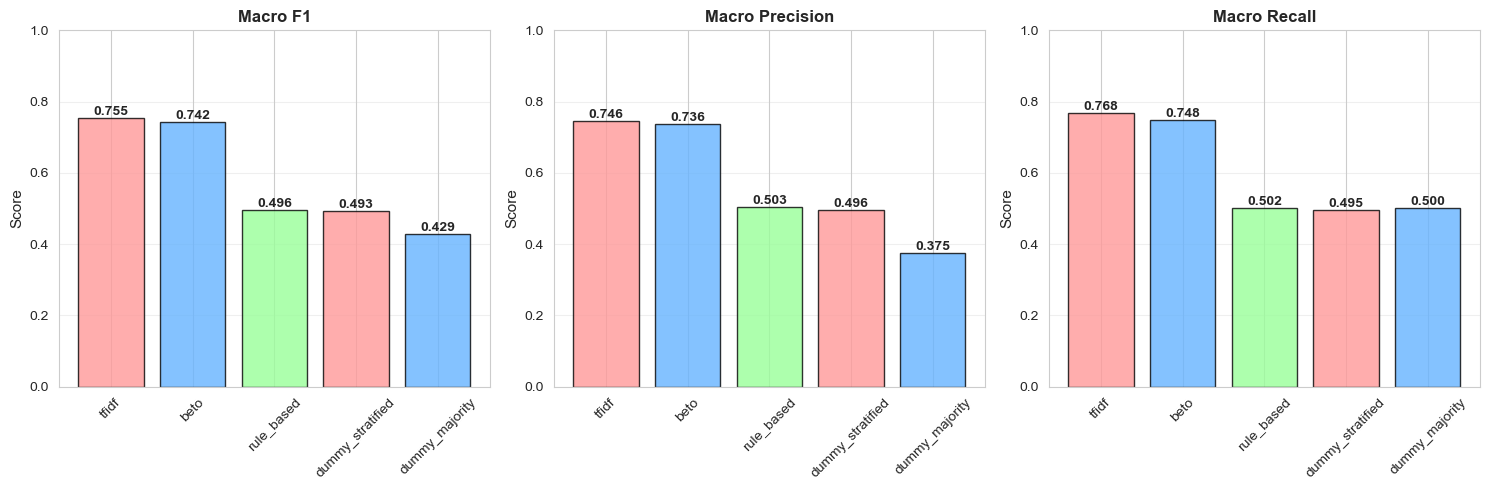


 Tabla resumen de resultados:


,baseline,macro_f1,macro_precision,macro_recall,n_val
0,tfidf,0.7553,0.7458,0.7684,646.000000
1,beto,0.7416,0.7364,0.7477,646.000000
2,rule_based,0.4963,0.5034,0.5024,646.000000
3,dummy_stratified,0.4934,0.4960,0.4955,646.000000
4,dummy_majority,0.4288,0.3754,0.5000,646.000000


In [47]:
# ===============================================================
# Gráfica de barras comparativa de métricas principales
# ===============================================================

# Detectar el formato de columnas (con o sin dummy baselines)
if 'f1_macro' in comp.columns:
    # Formato con dummy baselines
    comp_plot = comp.copy()
    comp_plot = comp_plot.rename(columns={
        'modelo': 'baseline',
        'f1_macro': 'macro_f1',
        'precision_macro': 'macro_precision',
        'recall_macro': 'macro_recall'
    })
else:
    comp_plot = comp.copy()

# Filtrar solo baselines con métricas (no None)
comp_clean = comp_plot[comp_plot['macro_f1'].notna()].copy()

if len(comp_clean) == 0:
    print("[WARNING] No hay métricas disponibles para visualizar.")
    print(" Ejecuta los 3 baselines primero.")
else:
    # Preparar datos para plotting
    metrics_to_plot = ['macro_f1', 'macro_precision', 'macro_recall']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]

        # Definir colores según tipo (dummy vs ML)
        if 'dummy' in comp_clean['baseline'].iloc[0]:
            colors = []
            for baseline in comp_clean['baseline']:
                if 'dummy' in baseline:
                    colors.append('#d62728')  # rojo para dummy
                else:
                    colors.append('#2ca02c')  # verde para ML
        else:
            colors = ['#ff9999', '#66b3ff', '#99ff99'][:len(comp_clean)]

        # Crear barplot
        bars = ax.bar(comp_clean['baseline'], comp_clean[metric], color=colors, alpha=0.8, edgecolor='black')

        # Añadir valores encima de las barras
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Configurar ejes
        ax.set_ylim(0, 1.0)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Rotar etiquetas si hay muchos modelos
        if len(comp_clean) > 3:
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(FIGS_PATH / '02_comparacion_metricas.png', dpi=150, bbox_inches='tight')
    print(f"[OK] Gráfica guardada: {FIGS_PATH / '02_comparacion_metricas.png'}")
    plt.show()

    # Mostrar tabla resumen
    print("\n Tabla resumen de resultados:")
    print("="*80)
    display(comp_clean.style.format({
        'macro_f1': '{:.4f}',
        'macro_precision': '{:.4f}',
        'macro_recall': '{:.4f}',
        'n': '{:.0f}'
    }).background_gradient(subset=['macro_f1', 'macro_precision', 'macro_recall'], 
                        cmap='RdYlGn', vmin=0, vmax=1))


## 3) Análisis por clase (Depresión vs Ansiedad)

[OK] Gráfica guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_por_clase.png


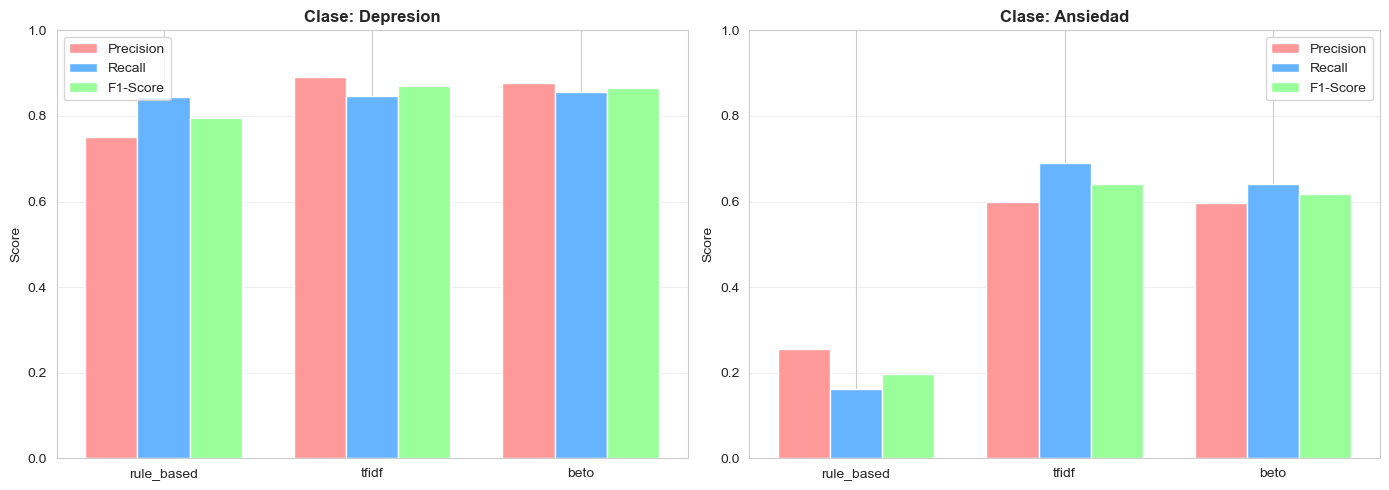


 Resultados detallados por clase:


clase,ansiedad,depresion
baseline,,
beto,0.6168,0.8664
rule_based,0.1977,0.7949
tfidf,0.6416,0.8689


In [48]:
# ===============================================================
# Comparar desempeño por clase usando classification reports
# ===============================================================

per_class_results = []

for name, ps in paths.items():
    if ps["report"].exists():
        report_df = pd.read_csv(ps["report"], index_col=0)
        
        # Extraer métricas por clase (depresion y ansiedad)
        for clase in ['depresion', 'ansiedad']:
            if clase in report_df.index:
                per_class_results.append({
                    'baseline': name,
                    'clase': clase,
                    'precision': report_df.loc[clase, 'precision'],
                    'recall': report_df.loc[clase, 'recall'],
                    'f1-score': report_df.loc[clase, 'f1-score']
                })

if per_class_results:
    df_per_class = pd.DataFrame(per_class_results)
    
    # Visualización por clase
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, clase in enumerate(['depresion', 'ansiedad']):
        ax = axes[idx]
        data_clase = df_per_class[df_per_class['clase'] == clase]
        
        if len(data_clase) > 0:
            x = np.arange(len(data_clase))
            width = 0.25
            
            # Barras para cada métrica
            ax.bar(x - width, data_clase['precision'], width, label='Precision', color='#ff9999')
            ax.bar(x, data_clase['recall'], width, label='Recall', color='#66b3ff')
            ax.bar(x + width, data_clase['f1-score'], width, label='F1-Score', color='#99ff99')
            
            ax.set_ylabel('Score')
            ax.set_title(f'Clase: {clase.capitalize()}', fontsize=12, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(data_clase['baseline'])
            ax.legend()
            ax.set_ylim(0, 1.0)
            ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGS_PATH / '02_comparacion_por_clase.png', dpi=150, bbox_inches='tight')
    print(f"[OK] Gráfica guardada: {FIGS_PATH / '02_comparacion_por_clase.png'}")
    plt.show()
    
    # Tabla de resultados por clase
    print("\n Resultados detallados por clase:")
    print("="*80)
    pivot_f1 = df_per_class.pivot(index='baseline', columns='clase', values='f1-score')
    display(pivot_f1.style.format('{:.4f}').background_gradient(cmap='RdYlGn', vmin=0, vmax=1))
else:
    print("[WARNING] No hay reportes de clasificación disponibles.")

## 4) Interpretación de resultados y recomendaciones

## 4) Análisis Completo

Para análisis detallado de resultados, errores, y próximos pasos, ver:

**📄 `RESULTADOS_BASELINES_README.md`**

Este documento incluye:
- ✅ Resultados por clase (Depresión vs Ansiedad)
- ✅ Matrices de confusión interpretadas
- ✅ Análisis de errores sistemáticos (5 categorías principales)
- ✅ Comparación con/sin data leakage
- ✅ Fortalezas/debilidades de cada modelo
- ✅ Validación de calidad (dummy baselines, casos conflictivos)
- ✅ Implicaciones para tesis y defensa

**📄 `PLAN_3_SEMANAS.md`**

Plan detallado para cierre de baselines y presentación:
- Semana 1: Validación y análisis de casos difíciles
- Semana 2: Experimentos de mejora (ensemble, vocabulario PY)
- Semana 3: Consolidación y presentación

---

### Resumen Ejecutivo

| Modelo | F1 Macro | F1 Depresión | F1 Ansiedad |
|--------|----------|--------------|-------------|
| **TF-IDF char(3,5)** | **0.755** | 0.869 | 0.642 |
| **BETO fine-tuned** | **0.742** | 0.866 | 0.617 |
| **Rule-based (COL)** | **0.496** | 0.795 | 0.198 |

**Conclusión:** TF-IDF y BETO tienen performance equivalente (diferencia de 1.3%, no significativa). El problema A/D es fundamentalmente léxico-discriminativo.